#  Import Libraries 

In [1]:
import os
import pandas as pd
import pymysql
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import eli5
import warnings
from pymysql.err import MySQLError
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import export_graphviz
import graphviz
from matplotlib import colormaps
from matplotlib.cm import get_cmap, ScalarMappable
from sklearn.tree import plot_tree
from eli5 import show_weights, explain_weights_df


warnings.filterwarnings("ignore", category=UserWarning)

#  Load Dataset from MySQL 

In [2]:
try:
    connection = pymysql.connect(
        host='localhost',
        user='root',
        password='First@445',
        database='customer'
    )
    
    df_joined = pd.read_sql("SELECT * FROM joined", connection)
    df_churned = pd.read_sql("SELECT * FROM churned", connection)
    
    connection.close()
    print("Dataset Loaded Sucessully")
except MySQLError as e:
    print("SQL error:", e)

Dataset Loaded Sucessully


#  Data Preprocessing 

In [3]:
df_churned = df_churned.drop(['customer_id', 'churn_category', 'churn_reason'], axis=1)
categorical_cols = df_churned.select_dtypes(include=['object']).columns.tolist()
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_churned[col] = le.fit_transform(df_churned[col])
    label_encoders[col] = le

In [4]:
#  Split Features and Target 
X = df_churned.drop('customer_status', axis=1)
y = df_churned['customer_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#  Random Forest Hyperparameter Tuning 

In [5]:
rf_model = RandomForestClassifier(
    n_estimators=1000,
    n_jobs=-1,
    random_state=42
)

# Train the model
rf_model.fit(X_train, y_train)

,n_estimators,1000
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


# Evaluate Model

In [6]:
# Testing the model
y_pred = rf_model.predict(X_test)

In [7]:
# Accuracy Score 
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 84.69%


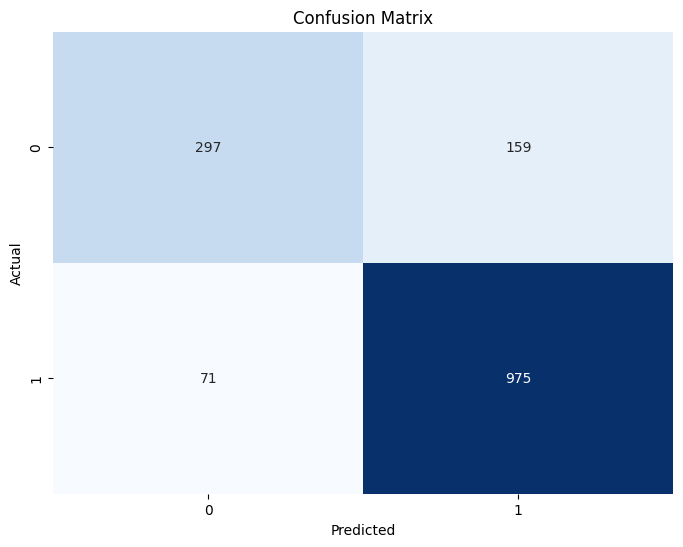

In [8]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [9]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.65      0.72       456
           1       0.86      0.93      0.89      1046

    accuracy                           0.85      1502
   macro avg       0.83      0.79      0.81      1502
weighted avg       0.84      0.85      0.84      1502



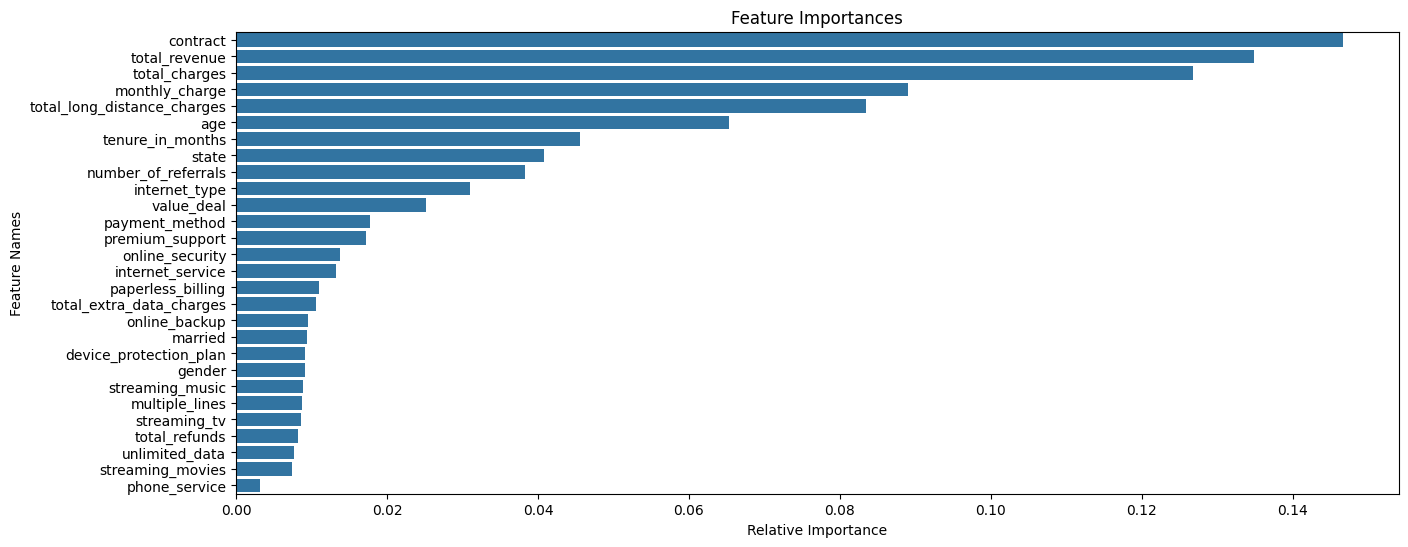

In [10]:
#  Feature Importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(15,6))
sns.barplot(x=importances[indices], y=X.columns[indices])
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.ylabel('Feature Names')
plt.show()

#  ELI5 Integration 

In [17]:
display(eli5.show_weights(rf_model, feature_names=list(X.columns)))

eli5_df = explain_weights_df(rf_model, feature_names=list(X.columns))
eli5_df

Weight,Feature
0.1467 ± 0.1597,contract
0.1349 ± 0.1414,total_revenue
0.1268 ± 0.1279,total_charges
0.0890 ± 0.0500,monthly_charge
0.0834 ± 0.0803,total_long_distance_charges
0.0653 ± 0.0238,age
0.0455 ± 0.0163,tenure_in_months
0.0408 ± 0.0153,state
0.0383 ± 0.0140,number_of_referrals
0.0309 ± 0.0477,internet_type


,feature,weight,std
0,contract,0.146695,0.079864
1,total_revenue,0.134918,0.070725
2,total_charges,0.126816,0.063952
3,monthly_charge,0.089039,0.025019
4,total_long_distance_charges,0.083402,0.040146
5,age,0.065346,0.011891
6,tenure_in_months,0.045521,0.008131
7,state,0.040827,0.007668
8,number_of_referrals,0.038274,0.007007
9,internet_type,0.030935,0.023841


In [19]:
# Pick a few random samples to explain
sample_indices = np.random.choice(X_test.index, size=3, replace=False)

for i, idx in enumerate(sample_indices):
    print(f"\n🔍 Explanation for Sample {i+1} (Index: {idx}) - Actual: {y_test.loc[idx]}, Predicted: {y_pred[list(X_test.index).index(idx)]}\n")
    display(eli5.show_prediction(
        rf_model,
        X_test.loc[idx],
        feature_names=list(X.columns),
        show_feature_values=True
    ))


🔍 Explanation for Sample 1 (Index: 1223) - Actual: 0, Predicted: 0




🔍 Explanation for Sample 2 (Index: 248) - Actual: 1, Predicted: 1




🔍 Explanation for Sample 3 (Index: 3731) - Actual: 0, Predicted: 0



#  Make Predictions on Joined Data 

In [11]:
df_prediction = df_joined.drop(['churn_category', 'churn_reason'], axis=1)
df_features = df_joined.drop(['customer_id', 'churn_category', 'customer_status', 'churn_reason'], axis=1)

In [12]:
for col in df_features.select_dtypes(include=['object']).columns:
    if col in label_encoders:
        df_features[col] = label_encoders[col].transform(df_features[col])
    else:
        df_features[col] = LabelEncoder().fit_transform(df_features[col])

In [13]:
predictions = rf_model.predict(df_features)
df_prediction['prediction'] = np.where(predictions==0, 'stay', 'churn')

# Export Predictions Data

In [14]:
df_prediction.to_csv("prediction.csv", index=False, encoding='utf-8')

# Decision Tree

In [15]:
#   Create a new folder 
output_folder = "decision_tree_trained"
os.makedirs(output_folder, exist_ok=True)  # Creates folder if it doesn't exist

#   Select a single tree from your Random Forest 
tree = rf_model.estimators_[0]
feature_names = [col for col in df_churned.columns if col != "customer_status"]

#   Get global feature importances 
importances = rf_model.feature_importances_
importance_map = {feature_names[i]: importances[i] for i in range(len(feature_names))}

#   Set up color maps (new API) 
fill_cmap = colormaps["Blues"]
border_cmap = colormaps["plasma"]
max_imp, min_imp = max(importances), min(importances)

#   Helper: feature importance → border color 
def feature_to_border_color(feature):
    if feature not in importance_map:
        return "#999999"  # leaf node
    norm_value = (importance_map[feature] - min_imp) / (max_imp - min_imp + 1e-9)
    rgba = border_cmap(norm_value)
    r, g, b, a = [int(x * 255) for x in rgba]
    return f"#{r:02x}{g:02x}{b:02x}"

#   Export raw DOT file 
dot_path = os.path.join(output_folder, "tree_hybrid_trained.dot")
export_graphviz(
    tree,
    out_file=dot_path,
    feature_names=feature_names,
    filled=True,
    rounded=True,
    special_characters=True,
    proportion=True,
    precision=2
)

#   Inject border colors into the DOT file 
colored_lines = []
with open(dot_path) as f:
    for line in f:
        if "label=" in line:
            for feature in feature_names:
                if f"{feature} " in line or f"{feature}<=" in line:
                    border_color = feature_to_border_color(feature)
                    line = line.replace("];", f', color="{border_color}", penwidth=3];')
                    break
        colored_lines.append(line)

colored_dot_path = os.path.join(output_folder, "tree_hybrid_colored_trained.dot")
with open(colored_dot_path, "w") as f:
    f.writelines(colored_lines)

#   Convert to SVG 
with open(colored_dot_path) as f:
    dot_graph = f.read()

graph = graphviz.Source(dot_graph)
graph.render(os.path.join(output_folder, "decision_tree_trained"), format="svg", cleanup=True)

'decision_tree_trained\\decision_tree_trained.svg'

In [16]:
#   Create a new folder 
output_folder = "decision_tree_precdition"
os.makedirs(output_folder, exist_ok=True)  # Creates folder if it doesn't exist

#   Select a single tree from your Random Forest 
tree = rf_model.estimators_[0]
feature_names = [col for col in df_features.columns if col != "customer_status"]

#   Get global feature importances 
importances = rf_model.feature_importances_
importance_map = {feature_names[i]: importances[i] for i in range(len(feature_names))}

#   Set up color maps (new API) 
fill_cmap = colormaps["Blues"]
border_cmap = colormaps["plasma"]
max_imp, min_imp = max(importances), min(importances)

#   Helper: feature importance → border color 
def feature_to_border_color(feature):
    if feature not in importance_map:
        return "#999999"  # leaf node
    norm_value = (importance_map[feature] - min_imp) / (max_imp - min_imp + 1e-9)
    rgba = border_cmap(norm_value)
    r, g, b, a = [int(x * 255) for x in rgba]
    return f"#{r:02x}{g:02x}{b:02x}"

#   Export raw DOT file 
dot_path = os.path.join(output_folder, "tree_hybrid_precdition.dot")
export_graphviz(
    tree,
    out_file=dot_path,
    feature_names=feature_names,
    filled=True,
    rounded=True,
    special_characters=True,
    proportion=True,
    precision=2
)

#   Inject border colors into the DOT file 
colored_lines = []
with open(dot_path) as f:
    for line in f:
        if "label=" in line:
            for feature in feature_names:
                if f"{feature} " in line or f"{feature}<=" in line:
                    border_color = feature_to_border_color(feature)
                    line = line.replace("];", f', color="{border_color}", penwidth=3];')
                    break
        colored_lines.append(line)

colored_dot_path = os.path.join(output_folder, "tree_hybrid_colored_precdition.dot")
with open(colored_dot_path, "w") as f:
    f.writelines(colored_lines)

#   Convert to SVG 
with open(colored_dot_path) as f:
    dot_graph = f.read()

graph = graphviz.Source(dot_graph)

graph.render(os.path.join(output_folder, "decision_tree_precdition"), format="svg", cleanup=True)

'decision_tree_precdition\\decision_tree_precdition.svg'